# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [2]:
# Load the cleaned dataset
df = pd.read_csv("zillow_cleaned.csv")

# Check load was a success
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74722 entries, 0 to 74721
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         74722 non-null  float64
 1   bathroomcnt                   74722 non-null  float64
 2   bedroomcnt                    74722 non-null  float64
 3   buildingqualitytypeid         74722 non-null  float64
 4   calculatedbathnbr             74722 non-null  float64
 5   calculatedfinishedsquarefeet  74722 non-null  float64
 6   finishedsquarefeet12          74722 non-null  float64
 7   fips                          74722 non-null  float64
 8   fullbathcnt                   74722 non-null  float64
 9   garagecarcnt                  74722 non-null  float64
 10  garagetotalsqft               74722 non-null  float64
 11  heatingorsystemtypeid         74722 non-null  float64
 12  latitude                      74722 non-null  float64
 13  l

In [3]:
df.head()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,...,poolcnt,propertylandusetypeid,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,numberofstories,assessmentyear,taxvaluedollarcnt
0,1.0,3.5,4.0,8.0,3.5,3100.0,3100.0,6059.0,3.0,2.0,...,0.0,261.0,53571.0,1286.0,0.0,1.0,1998.0,1.0,2016.0,1023282.0
1,1.0,1.0,2.0,8.0,1.0,1465.0,1465.0,6111.0,1.0,1.0,...,0.0,261.0,13091.0,2061.0,5.0,1.0,1967.0,1.0,2016.0,464000.0
2,1.0,2.0,3.0,8.0,2.0,1243.0,1243.0,6059.0,2.0,2.0,...,1.0,261.0,21412.0,1286.0,6.0,1.0,1962.0,1.0,2016.0,564778.0
3,1.0,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,...,1.0,261.0,396551.0,3101.0,0.0,1.0,1970.0,1.0,2016.0,145143.0
4,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,...,1.0,266.0,12447.0,3101.0,0.0,1.0,1964.0,1.0,2016.0,119407.0


In [4]:
# Create train/test split
X = df.drop(columns=['taxvaluedollarcnt'])
y = df['taxvaluedollarcnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Make a copy before applying changes
X_train_copy = X_train.copy()

In [6]:
# Standardize the features of the training set
scalar = StandardScaler()
scaled_data = scalar.fit_transform(X_train_copy)

# Convert back to df to mantain column names
X_train_scaled = pd.DataFrame(scaled_data, columns=X_train_copy.columns, index=X_train_copy.index)

### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [7]:
# Define repeated k-fold cv
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

In [8]:
# Define a function that runs models at default parameters
# Returns mean and standard deviation of CV RMSE Scores
def baseline_models(model, X_train, y_train, cv=rkf, n_jobs=-1):

    if isinstance(model, type):
        model = model()

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error', cv=cv, n_jobs=n_jobs)
    
    mean_cv_rmse = (-np.mean(neg_mse_scores))**0.5
    std_cv_rmse  = np.std(neg_mse_scores)**0.5
    
    return mean_cv_rmse, std_cv_rmse

In [9]:
from sklearn.tree import DecisionTreeRegressor

# Define list of models that will be explored
models = [LinearRegression(),
          Ridge(random_state=42),
          Lasso(random_state=42),
          DecisionTreeRegressor(random_state=42),
          BaggingRegressor(random_state=42),
          RandomForestRegressor(random_state=42, n_jobs=1),
          GradientBoostingRegressor(random_state=42)]

In [10]:
import gc

# Define empty dictionary to store results
baseline_results = {}

for model in models:
    model_name = model.__class__.__name__
    mean_cv_rmse, std_cv_rmse = baseline_models(model, X_train_scaled, y_train)
    baseline_results[model_name] = {'Mean CV RMSE': mean_cv_rmse, 'Std CV RMSE': std_cv_rmse}

    del model  # explicitly delete model
    gc.collect()  # clean up memory

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [11]:
BL_results = pd.DataFrame(baseline_results).T
BL_results['Mean CV RMSE ($)'] = BL_results['Mean CV RMSE'].apply(lambda x: f"${x:,.2f}")
BL_results['Std CV RMSE ($)'] = BL_results['Std CV RMSE'].apply(lambda x: f"${x:,.2f}")
BL_results_selected = BL_results[['Mean CV RMSE ($)', 'Std CV RMSE ($)']]
BL_results_selected

,Mean CV RMSE ($),Std CV RMSE ($)
LinearRegression,"$282,797.20","$48,534.84"
Ridge,"$282,796.09","$48,584.81"
Lasso,"$282,796.12","$48,584.76"
DecisionTreeRegressor,"$342,043.86","$52,791.11"
BaggingRegressor,"$258,738.59","$41,665.12"
RandomForestRegressor,"$248,077.11","$40,015.54"
GradientBoostingRegressor,"$251,755.84","$42,561.17"


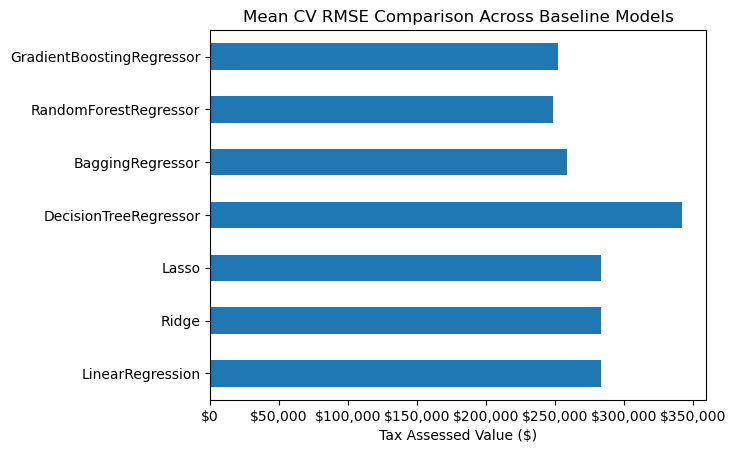

In [12]:
from matplotlib.ticker import FuncFormatter
ax = BL_results['Mean CV RMSE'].plot.barh()
plt.title('Mean CV RMSE Comparison Across Baseline Models')
plt.xlabel('Tax Assessed Value ($)')

# Format axis
formatter = FuncFormatter(lambda x, _: f'${x:,.0f}')
ax.xaxis.set_major_formatter(formatter)

plt.show()

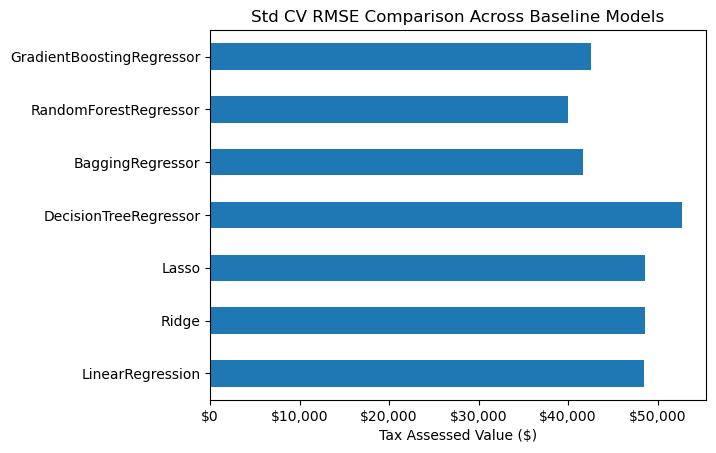

In [13]:
ax = BL_results['Std CV RMSE'].plot.barh()
plt.title('Std CV RMSE Comparison Across Baseline Models')
plt.xlabel('Tax Assessed Value ($)')
ax.xaxis.set_major_formatter(formatter)
plt.show()

### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

- Which models perform best overall?
> After comparing all seven models, the top three models that performed best overall were random forest regressor, bagging regressor, and gradient boosting regressor, respectively.

- Which are most stable (lowest std)?
> Random forest regressor has the lowest standard deviation and appears to be the most stable at this point. This is followed by bagging regressor which has a lower standard deviation than the gradient boosting regressor.

- Any signs of overfitting or underfitting?
> The decision tree regressor has a much higher mean and standard deviation RMSE than the other models which could indicate underfitting and inconsistency across folds.

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [14]:
# Create a copy of the original X_train and X_test for feature engineering
X_train_engineered_features = X_train.copy()
X_test_engineered_features = X_test.copy()

# Create three new features
X_train_engineered_features['log_lot_size'] = np.log(X_train_engineered_features['lotsizesquarefeet'])
X_train_engineered_features['bed_bath'] = X_train_engineered_features['bathroomcnt'] * X_train_engineered_features['bedroomcnt']
X_train_engineered_features['house_age'] = 2019 - X_train_engineered_features['yearbuilt']

# Add features to X_test for consistency
X_test_engineered_features['log_lot_size'] = np.log(X_test_engineered_features['lotsizesquarefeet'])
X_test_engineered_features['bed_bath'] = X_test_engineered_features['bathroomcnt'] * X_test_engineered_features['bedroomcnt']
X_test_engineered_features['house_age'] = 2019 - X_test_engineered_features['yearbuilt']

# Check to make sure features were added
count_added = len(X_train_engineered_features.columns) - len(X_train.columns)
print(f'Features added: {count_added}')

Features added: 3


In [15]:
# Standardize the features of the training set with new engineered features and apply transformation to X_test
scalar_eng = StandardScaler()
X_train_eng_scaled_data = scalar_eng.fit_transform(X_train_engineered_features)
X_test_eng_scaled_data = scalar_eng.transform(X_test_engineered_features)

# Convert back to df to mantain column names
X_train_eng_scaled = pd.DataFrame(X_train_eng_scaled_data, columns=X_train_engineered_features.columns, index=X_train_engineered_features.index)
X_test_eng_scaled = pd.DataFrame(X_test_eng_scaled_data, columns=X_test_engineered_features.columns, index=X_test_engineered_features.index)

In [16]:
eng_results = {}

# Define list of models that will be explored
eng_models = [LinearRegression(),
              Ridge(random_state=42),
              Lasso(random_state=42),
              DecisionTreeRegressor(random_state=42),
              BaggingRegressor(random_state=42),
              RandomForestRegressor(random_state=42, n_jobs=1),
              GradientBoostingRegressor(random_state=42)]

for model in eng_models:
    model_name = model.__class__.__name__
    mean_cv_rmse, std_cv_rmse = baseline_models(model, X_train_eng_scaled, y_train)
    eng_results[model_name] = {'Mean CV RMSE w/ Feature Eng': mean_cv_rmse, 'Std CV RMSE w/ Feature Eng': std_cv_rmse}

    del model  # explicitly delete model
    gc.collect()  # clean up memory

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
engineered_results = pd.DataFrame(eng_results).T
engineered_results['Mean CV RMSE w/ Feature Eng ($)'] = engineered_results['Mean CV RMSE w/ Feature Eng'].apply(lambda x: f"${x:,.2f}")
engineered_results['Std CV RMSE w/ Feature Eng ($)'] = engineered_results['Std CV RMSE w/ Feature Eng'].apply(lambda x: f"${x:,.2f}")
engineered_results_selected = engineered_results[['Mean CV RMSE w/ Feature Eng ($)', 'Std CV RMSE w/ Feature Eng ($)']]
engineered_results_selected

,Mean CV RMSE w/ Feature Eng ($),Std CV RMSE w/ Feature Eng ($)
LinearRegression,"$282,565.65","$48,456.61"
Ridge,"$282,538.17","$48,542.87"
Lasso,"$282,538.21","$48,542.80"
DecisionTreeRegressor,"$342,188.81","$50,701.56"
BaggingRegressor,"$258,629.80","$40,899.12"
RandomForestRegressor,"$248,069.05","$40,217.49"
GradientBoostingRegressor,"$251,683.34","$42,686.43"


In [18]:
Combined_results = pd.concat([BL_results_selected, engineered_results_selected], axis=1)
Combined_results

,Mean CV RMSE ($),Std CV RMSE ($),Mean CV RMSE w/ Feature Eng ($),Std CV RMSE w/ Feature Eng ($)
LinearRegression,"$282,797.20","$48,534.84","$282,565.65","$48,456.61"
Ridge,"$282,796.09","$48,584.81","$282,538.17","$48,542.87"
Lasso,"$282,796.12","$48,584.76","$282,538.21","$48,542.80"
DecisionTreeRegressor,"$342,043.86","$52,791.11","$342,188.81","$50,701.56"
BaggingRegressor,"$258,738.59","$41,665.12","$258,629.80","$40,899.12"
RandomForestRegressor,"$248,077.11","$40,015.54","$248,069.05","$40,217.49"
GradientBoostingRegressor,"$251,755.84","$42,561.17","$251,683.34","$42,686.43"


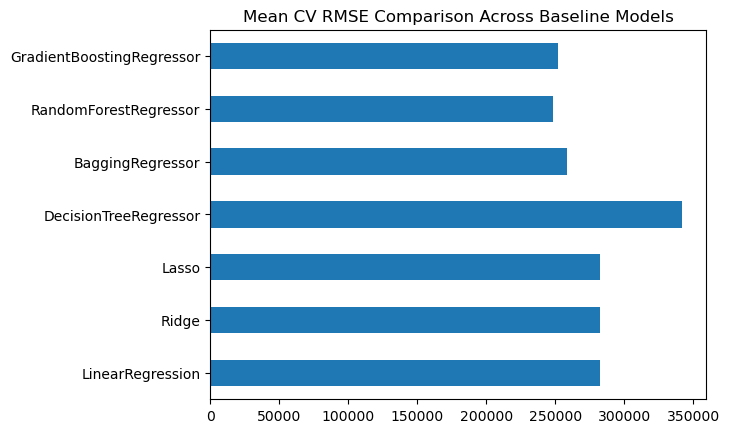

In [19]:
engineered_results['Mean CV RMSE w/ Feature Eng'].plot.barh()
plt.title('Mean CV RMSE Comparison Across Baseline Models')
plt.show()

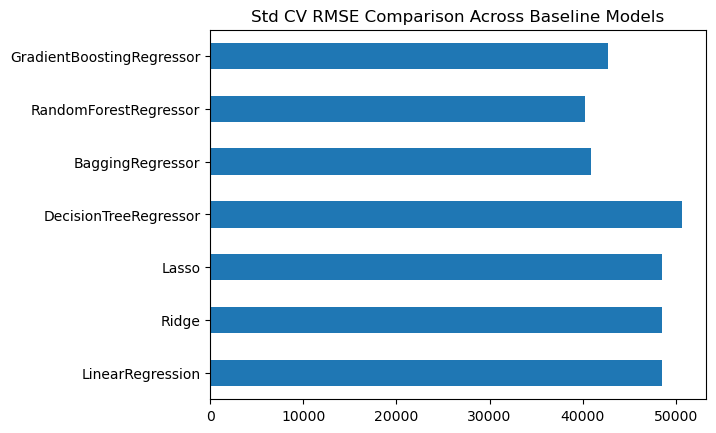

In [20]:
engineered_results['Std CV RMSE w/ Feature Eng'].plot.barh()
plt.title('Std CV RMSE Comparison Across Baseline Models')
plt.show()

### Comparison Between Baseline Models and Models After Feature Engineering

In [21]:
BL_results_graph = BL_results[['Mean CV RMSE', 'Std CV RMSE']]
engineered_results_graph = engineered_results[['Mean CV RMSE w/ Feature Eng', 'Std CV RMSE w/ Feature Eng']]
combined_results_graph = pd.concat([BL_results_graph, engineered_results_graph], axis=1)

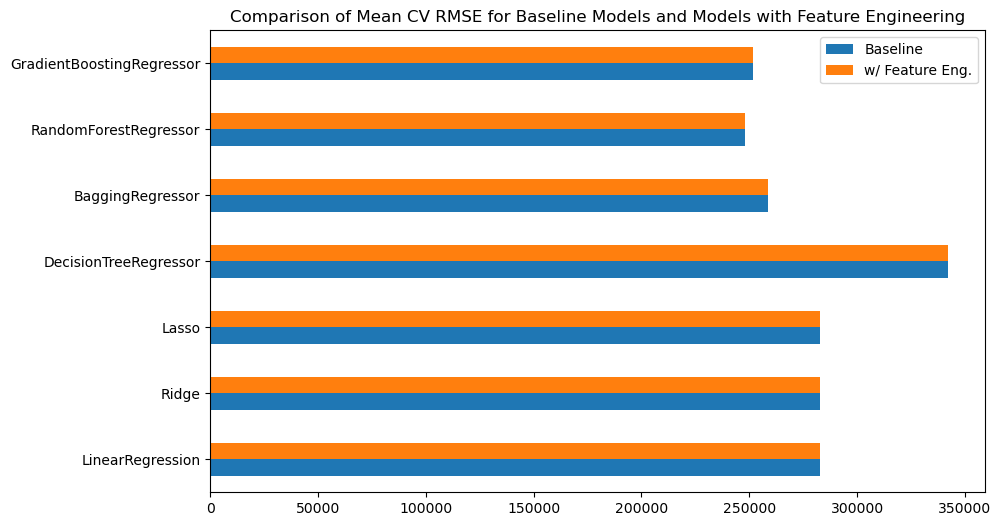

In [22]:
combined_results_graph[['Mean CV RMSE', 'Mean CV RMSE w/ Feature Eng']].plot.barh(figsize=(10, 6))
plt.title('Comparison of Mean CV RMSE for Baseline Models and Models with Feature Engineering')
plt.legend(['Baseline', 'w/ Feature Eng.'])
plt.show()

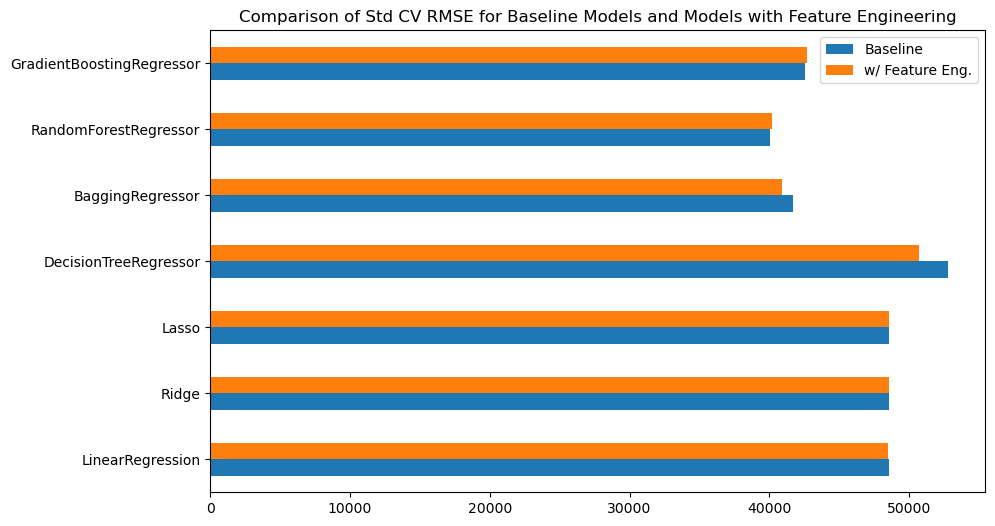

In [23]:
combined_results_graph[['Std CV RMSE', 'Std CV RMSE w/ Feature Eng']].plot.barh(figsize=(10, 6))
plt.title('Comparison of Std CV RMSE for Baseline Models and Models with Feature Engineering')
plt.legend(['Baseline', 'w/ Feature Eng.'])
plt.show()

### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?





- Did any models show notable improvement in performance?

> After adding the new features, We didn’t see any major improvements across the models. Most of the changes were pretty minimal. For example, Linear Regression showed a small improvement in RMSE, but nothing significant. Ridge Regression stood out a little more — it had a slight improvement in performance, and its standard deviation went down, which suggests it became a bit more consistent. Lasso followed a similar pattern with a small gain. On the other hand, Decision Trees actually performed slightly worse, and for models like Bagging, Random Forest, and Gradient Boosting, the RMSE either stayed the same or got slightly worse, while the standard deviation increased. So while there were some shifts, we wouldn’t call any of them a notable improvement — just small changes overall.


- Which new features seemed to help — and in which models?

>The log transformation didn’t make a significant difference in terms of model performance or in feature selection based on F-statistics. However, the bed_bath_product seemed to help slightly in Linear, Ridge, and Lasso Regression, possibly because it better captures home size and utility compared to the individual room counts alone. The location interaction (longitude × latitude) had a limited effect but may have contributed some value in tree-based models like Random Forest and Gradient Boosting, which can better capture non-linear spatial relationships. Overall, bed_bath_product was the most consistently helpful feature across models that rely on linear relationships.

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

>One hypothesis is that the log transformation of lot size didn’t help much because lot size may not have had a strong or direct relationship with home value in this dataset — or the skewness wasn’t severe enough to affect model performance. Additionally, log-transformed features can be less useful in tree-based models, which don’t assume linearity. The bed_bath_product feature likely helped more because it captures the combined scale of a home’s livable space. Instead of treating bedrooms and bathrooms separately, this interaction reflects the idea that homes with more total rooms tend to be more valuable — which aligns with how buyers perceive property size and utility. This could explain why it helped models like Linear Regression, Ridge, and Lasso, which benefit from well-structured numeric relationships. As for the longitude × latitude interaction, it may not have helped significantly because location is already captured fairly well by the individual coordinates, and we didn’t include other location-specific variables like zip code or neighborhood to support it. Spatial relationships might require more complex modeling (like clustering or spatial encoding) to show a stronger impact.

- Were there any unexpected results?
>Yes. We expected the log-transformed lot size to help more, but it had little impact on model performance. Surprisingly, Decision Trees and ensemble models like Bagging and Random Forest performed slightly worse after adding new features, with increased variance. On the other hand, Ridge Regression became more consistent, which was unexpected but positive.



### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


### Linear Regression

In [24]:
# Define model
model1 = LinearRegression()

# Forward selection 
forward_selector1 = SequentialFeatureSelector(model1, direction='forward', scoring='r2', cv=rkf)
forward_selector1.fit(X_train_eng_scaled, y_train)

# Get column names
features_selected1 = X_train_eng_scaled.columns[forward_selector1.get_support()]

# Print out features that were selected
print("Forward-selected features:")
print(features_selected1)

Forward-selected features:
Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'garagetotalsqft', 'latitude', 'longitude', 'poolcnt', 'roomcnt',
       'yearbuilt', 'numberofstories', 'log_lot_size'],
      dtype='object')


In [ ]:
# Run model using top features selected
X_train_subset1 = X_train_engineered_features[features_selected1]

# Run prelimary cross validation to check for robustness
mean_cv_rmse1, std_cv_rmse1 = baseline_models(model1, X_train_subset1, y_train)
print(f'Mean CV: ${mean_cv_rmse1:,.2f}')
print(f'Standard Deviation CV: ${std_cv_rmse1:,.2f}')

Mean CV: $283,092.33
Standard Deviation CV: $48,668.69


### Ridge

In [26]:
# Define model
model2 = Ridge()

# Forward selection 
forward_selector2 = SequentialFeatureSelector(model2, direction='forward', scoring='r2', cv=rkf)
forward_selector2.fit(X_train_eng_scaled, y_train)

# Get column names
features_selected2 = X_train_eng_scaled.columns[forward_selector2.get_support()]

# Print out features that were selected
print("Forward-selected features:")
print(features_selected2)

Forward-selected features:
Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'garagetotalsqft', 'latitude', 'longitude', 'poolcnt', 'roomcnt',
       'yearbuilt', 'numberofstories', 'log_lot_size'],
      dtype='object')


In [54]:
# Run model using top features selected
X_train_subset2 = X_train_engineered_features[features_selected2]

# Run prelimary cross validation to check for robustness
mean_cv_rmse2, std_cv_rmse2 = baseline_models(model2, X_train_subset2, y_train)
print(f'Mean CV: ${mean_cv_rmse2:,.2f}')
print(f'Standard Deviation CV: ${std_cv_rmse2:,.2f}')

Mean CV: $283,092.32
Standard Deviation CV: $48,668.78


### Lasso

In [28]:
# Define model
model3 = Lasso()

# Forward selection 
forward_selector3 = SequentialFeatureSelector(model3, direction='forward', scoring='r2', cv=rkf)
forward_selector3.fit(X_train_eng_scaled, y_train)

# Get column names
features_selected3 = X_train_eng_scaled.columns[forward_selector3.get_support()]

# Print out features that were selected
print("Forward-selected features:")
print(features_selected3)

Forward-selected features:
Index(['bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'garagetotalsqft', 'latitude', 'longitude', 'poolcnt', 'roomcnt',
       'yearbuilt', 'numberofstories', 'log_lot_size'],
      dtype='object')


In [55]:
# Run model using top features selected
X_train_subset3 = X_train_engineered_features[features_selected3]

# Run prelimary cross validation to check for robustness
mean_cv_rmse3, std_cv_rmse3 = baseline_models(model3, X_train_subset3, y_train)
print(f'Mean CV: ${mean_cv_rmse3:,.2f}')
print(f'Standard Deviation CV: ${std_cv_rmse3:,.2f}')

Mean CV: $283,092.33
Standard Deviation CV: $48,668.82


### Decision Tree

In [30]:
# Define model
model4 = DecisionTreeRegressor()

# Forward selection 
forward_selector4 = SequentialFeatureSelector(model4, direction='forward', scoring='r2', cv=rkf)
forward_selector4.fit(X_train_eng_scaled, y_train)

# Get column names
features_selected4 = X_train_eng_scaled.columns[forward_selector4.get_support()]

# Print out features that were selected
print("Forward-selected features:")
print(features_selected4)

Forward-selected features:
Index(['airconditioningtypeid', 'bathroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'fips', 'fullbathcnt', 'garagecarcnt',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'unitcnt',
       'numberofstories', 'assessmentyear'],
      dtype='object')


In [56]:
# Run model using top features selected
X_train_subset4 = X_train_engineered_features[features_selected4]

# Run prelimary cross validation to check for robustness
mean_cv_rmse4, std_cv_rmse4 = baseline_models(model4, X_train_subset4, y_train)
print(f'Mean CV: ${mean_cv_rmse4:,.2f}')
print(f'Standard Deviation CV: ${std_cv_rmse4:,.2f}')

Mean CV: $286,777.46
Standard Deviation CV: $46,239.78


### Bagging

In [32]:
# Define model
model5 = BaggingRegressor()

# Forward selection 
forward_selector5 = SequentialFeatureSelector(model5, direction='forward', scoring='r2', cv=rkf)
forward_selector5.fit(X_train_eng_scaled, y_train)

# Get column names
features_selected5 = X_train_eng_scaled.columns[forward_selector5.get_support()]

# Print out features that were selected
print("Forward-selected features:")
print(features_selected5)

Forward-selected features:
Index(['airconditioningtypeid', 'bathroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'fips', 'fullbathcnt', 'garagecarcnt',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'unitcnt',
       'numberofstories', 'assessmentyear'],
      dtype='object')


In [57]:
# Run model using top features selected
X_train_subset5 = X_train_engineered_features[features_selected5]

# Run prelimary cross validation to check for robustness
mean_cv_rmse5, std_cv_rmse5 = baseline_models(model5, X_train_subset5, y_train)
print(f'Mean CV: ${mean_cv_rmse5:,.2f}')
print(f'Standard Deviation CV: ${std_cv_rmse5:,.2f}')

Mean CV: $279,187.31
Standard Deviation CV: $47,602.20


### Random Forest

In [34]:
# Define model
model6 = RandomForestRegressor()

# Forward selection 
forward_selector6 = SequentialFeatureSelector(model6, direction='forward', scoring='r2', cv=rkf)
forward_selector6.fit(X_train_eng_scaled, y_train)

# Get column names
features_selected6 = X_train_eng_scaled.columns[forward_selector6.get_support()]

# Print out features that were selected
print("Forward-selected features:")
print(features_selected6)

Forward-selected features:
Index(['airconditioningtypeid', 'bathroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'fips', 'fullbathcnt', 'garagecarcnt',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'unitcnt',
       'numberofstories', 'assessmentyear'],
      dtype='object')


In [58]:
# Run model using top features selected
X_train_subset6 = X_train_engineered_features[features_selected6]

# Run prelimary cross validation to check for robustness
mean_cv_rmse6, std_cv_rmse6 = baseline_models(model6, X_train_subset6, y_train)
print(f'Mean CV: ${mean_cv_rmse6:,.2f}')
print(f'Standard Deviation CV: ${std_cv_rmse6:,.2f}')

Mean CV: $277,699.43
Standard Deviation CV: $46,516.77


### Gradient Boosting

In [36]:
# Define model
model7 = GradientBoostingRegressor()

# Forward selection 
forward_selector7 = SequentialFeatureSelector(model7, direction='forward', scoring='r2', cv=rkf)
forward_selector7.fit(X_train_eng_scaled, y_train)

# Get column names
features_selected7 = X_train_eng_scaled.columns[forward_selector7.get_support()]

# Print out features that were selected
print("Forward-selected features:")
print(features_selected7)

Forward-selected features:
Index(['bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'propertylandusetypeid',
       'regionidcity', 'bed_bath', 'house_age'],
      dtype='object')


In [59]:
# Run model using top features selected
X_train_subset7 = X_train_engineered_features[features_selected7]

# Run prelimary cross validation to check for robustness
mean_cv_rmse7, std_cv_rmse7 = baseline_models(model7, X_train_subset7, y_train)
print(f'Mean CV: ${mean_cv_rmse7:,.2f}')
print(f'Standard Deviation CV: ${std_cv_rmse7:,.2f}')

Mean CV: $251,730.22
Standard Deviation CV: $43,361.62


### Summary Table

In [60]:
summary_table = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Decision Tree', 'Bagging Regressor', 'Random Forest', 'Gradient Boosting'],
    'Mean CV RMSE': [mean_cv_rmse1, mean_cv_rmse2, mean_cv_rmse3, mean_cv_rmse4, mean_cv_rmse5, mean_cv_rmse6, mean_cv_rmse7],
    'Std Dev': [std_cv_rmse1, std_cv_rmse2, std_cv_rmse3, std_cv_rmse4, std_cv_rmse5, std_cv_rmse6, std_cv_rmse7]
})

print(summary_table)

               Model   Mean CV RMSE       Std Dev
0  Linear Regression  283092.325799  48668.690722
1              Ridge  283092.322017  48668.781025
2              Lasso  283092.326189  48668.821741
3      Decision Tree  286777.463294  46239.778264
4  Bagging Regressor  279187.308182  47602.199299
5      Random Forest  277699.433368  46516.774727
6  Gradient Boosting  251730.216698  43361.623046


In [64]:
from collections import Counter

selected_features_dict = {
    "model1": features_selected1.to_list(),
    "model2": features_selected2.to_list(),
    "model3": features_selected3.to_list(),
    "model4": features_selected4.to_list(),
    "model5": features_selected5.to_list(),
    "model6": features_selected6.to_list(),
    "model7": features_selected7.to_list()
}

all_features = sum(selected_features_dict.values(), [])
counts = Counter(all_features)

# Show features that appear in most models
print("Frequently selected features:")
for feature, count in counts.items():
    if count >= 4:  # Appears in at least 4 out of 7 models
        print(f"{feature}: selected by {count} models")

Frequently selected features:
bathroomcnt: selected by 5 models
bedroomcnt: selected by 4 models
buildingqualitytypeid: selected by 7 models
calculatedfinishedsquarefeet: selected by 4 models
finishedsquarefeet12: selected by 4 models
latitude: selected by 4 models
longitude: selected by 4 models
poolcnt: selected by 4 models
numberofstories: selected by 6 models
calculatedbathnbr: selected by 5 models
propertylandusetypeid: selected by 4 models
regionidcity: selected by 4 models


### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

- Did performance improve for any models after reducing the number of features?
> Yes, there was a significant improvement for the decision tree regressor. For Linear Regression, Ridge, and Lasso, the performance was virtually identical across the full feature set and all selected subsets. Any minor variations were well within the standard deviation and likely not statistically significant. For Random Forest, the best-performing model overall, performance slightly worsened when using features from Forward Selection (RMSE ≈ 277,699.43) compared to the full feature set (RMSE ≈ 248,077.11). For Gradient Boosting, performance remained remarkably consistent across all feature sets.


- Which features were consistently retained across models?<br>
> We found that building quality type id was selected by all 7 models. Number of stories was selected by 6 of the 7 models. Bathroom count and calculated bath and bedroom ratio were selected by 5 of the 7 models. The remaining features listed were selected in at least 4 of the 7 models: bedroom count, calculated finished square feet, finished square feet 12, latitude, longitude, pool count, property land use type id, and region id city.

- Were any of your newly engineered features selected as important?<br>
> Yes, the engineered features house age and log lot size appeared in the top feature list for a few of the models, but none of them were consistantly seen across all models. The bed_bath feature did not appear to be a significant addition as it did not appear in any of the top feature lists for any of the models.

- How did feature selection differ between linear and tree-based models?> <br>
> The tree-based selections were vastly more time-consuming and computational costly than the linear models for forward selection methods.

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



In [38]:
# Renamed scaled X_train and X_test
X_train_p4 = X_train_eng_scaled
X_test_p4 = X_test_eng_scaled

In [39]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), n_jobs  = n_jobs)
    
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse

In [40]:
# Add as many code cells as you need
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train_p4, # updated to scaled dataset
                    y_train          = y_train,
                    X_test           = X_test_p4, # updated to scaled dataset
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    no_improve_count = 0
    best_mse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('MSE_found', None)
        
        cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
        test_mses.append(test_mse)
        
        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_mse = min(cv_mses)
    min_index = cv_mses.index(min_cv_mse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MSE_found'] = min_cv_mse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_mses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 np.sqrt(cv_mses) if show_rmse else cv_mses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 np.sqrt(train_mses) if show_rmse else train_mses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.plot(x_vals,
                 np.sqrt(test_mses) if show_rmse else test_mses,
                 linestyle='--', label=f"Test {error_name}", color='orange')
        ax1.scatter([x_vals[min_index]],
                    [np.sqrt(min_cv_mse) if show_rmse else min_cv_mse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters

In [41]:
def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

In [42]:
def grid_search(model, param_grid):
    # Record start time
    start = time.time()

    # Use GridSearchCV to find the best parameters
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=RepeatedKFold(n_repeats=10, random_state=42),
        n_jobs=-1,
        return_train_score=True
    )

    # Fit the GridSearchCV
    search.fit(X_train, y_train)

    # Best parameters and test performance
    print(f"\nBest Parameters: {search.best_params_}")
    print(f"Best CV MSE: {-search.best_score_:.4f}")

    # Evaluate on the test set
    y_pred_bagging = search.best_estimator_.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_bagging)
    print(f"Test MSE: {test_mse:.4f}")  

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Record end time and execution time
    end = time.time()
    print(f"Execution Time: " + format_time(end-start))

    return search, results

### A. Bagging Regressor

In [43]:
# Define the parameters for the BaggingRegressor
Default_Parameters_Bagging = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

Sweeping n_estimators:   0%|          | 0/10 [00:00<?, ?it/s]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping n_estimators:  10%|█         | 1/10 [03:33<31:57, 213.05s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping n_estimators:  30%|███       | 3/10 [22:08<58:00, 497.20s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweepin

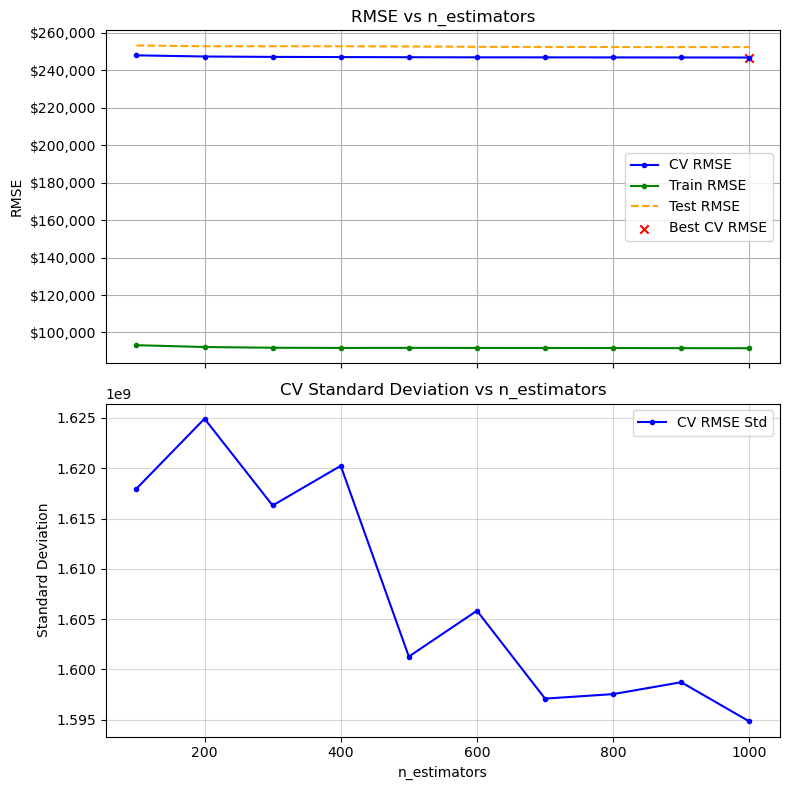

Execution Time: 03:40:23

Parameter n_estimators = 1000 RMSE = $246,843.01

{'n_estimators': 1000, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'MSE_found': 60931471009.58919}


Sweeping max_samples: 100%|██████████| 10/10 [02:14<00:00, 13.41s/it]


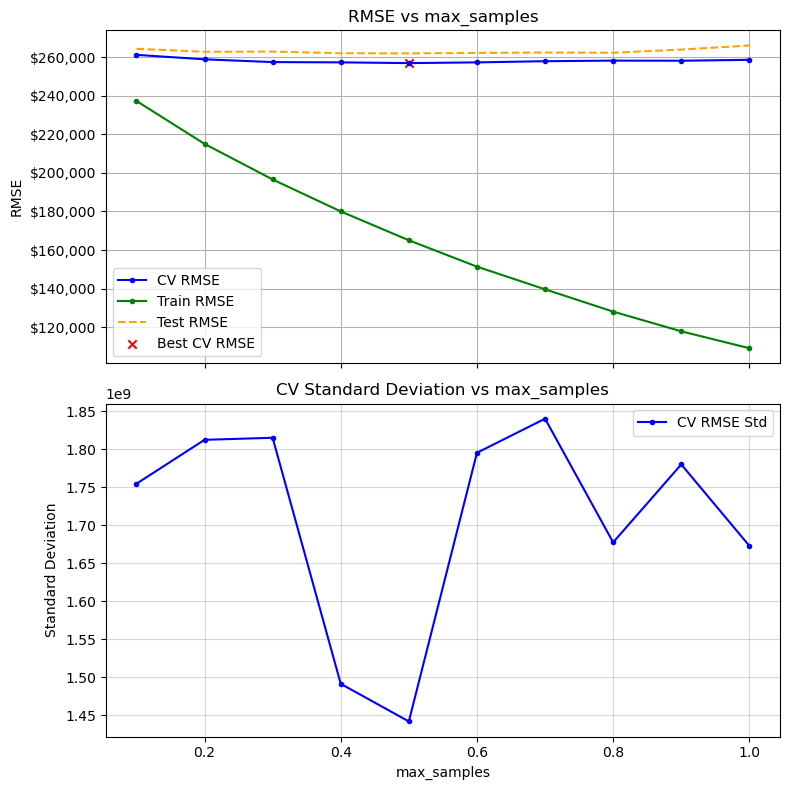

Execution Time: 00:02:14

Parameter max_samples = 0.5 RMSE = $256,933.89

{'n_estimators': 10, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'MSE_found': 66015025283.29151}


Sweeping max_features: 100%|██████████| 13/13 [02:41<00:00, 12.43s/it]


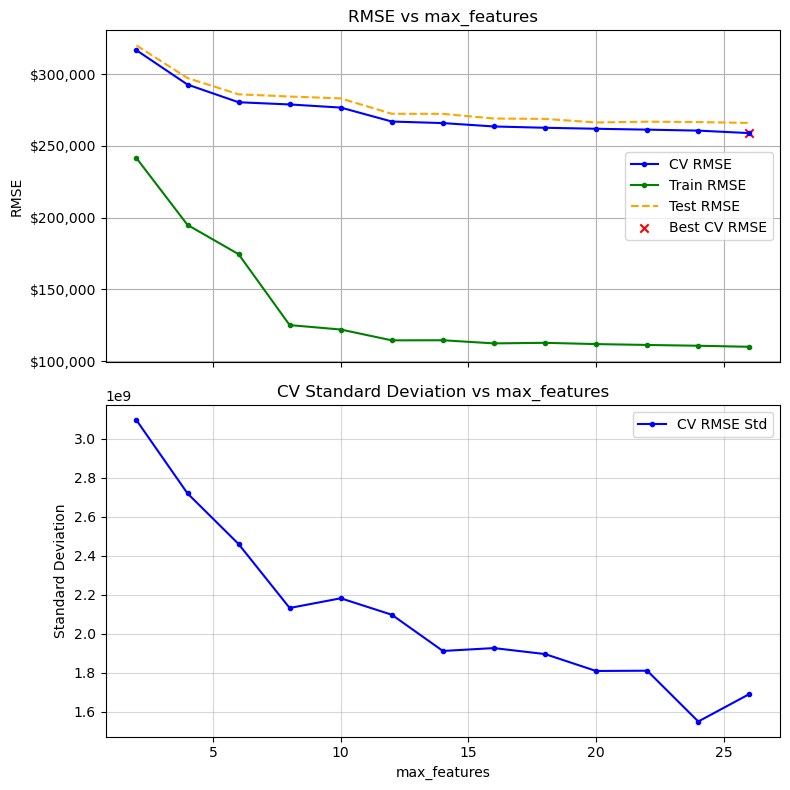

Execution Time: 00:02:41

Parameter max_features = 26 RMSE = $258,935.35

{'n_estimators': 10, 'max_samples': 1.0, 'max_features': 26, 'bootstrap': True, 'random_state': 42, 'MSE_found': 67047517876.9094}


In [44]:
# Make a copy of the default parameters dictionary
Param_Bagging_A = Default_Parameters_Bagging.copy()

# Define empty parameters list for storing
Param_Bagging_A_BT_list = []

# Define parameter changes
Param_Bagging_A_ranges = [('n_estimators', range(100, 1001, 100)),
                          ('max_samples', np.linspace(0.1, 1.0, 10)),
                          ('max_features', range(2, 28, 2)),
                          ]

# Test parameters
for (param, parameter_list) in Param_Bagging_A_ranges:
    Param_Bagging_A_BT = sweep_parameter(BaggingRegressor,
                                         Param_Bagging_A,
                                         param,
                                         parameter_list,
                                         n_repeats = 5
                                         )

    print(f"\nParameter {param} = {Param_Bagging_A_BT[param]} RMSE = ${Param_Bagging_A_BT['MSE_found']**0.5:,.2f}\n")
    print(Param_Bagging_A_BT)

    # Append best parameters
    Param_Bagging_A_BT_list.append(Param_Bagging_A_BT)

# Store best results in dataframe
results_a = pd.DataFrame(Param_Bagging_A_BT_list)


In [45]:
results_a

,n_estimators,max_samples,max_features,bootstrap,random_state,MSE_found
0,1000,1.0,1.0,True,42,6.093147e+10
1,10,0.5,1.0,True,42,6.601503e+10
2,10,1.0,26.0,True,42,6.704752e+10


In [69]:
from sklearn.pipeline import Pipeline

bagging_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', BaggingRegressor(random_state=42))
])

bagging_params = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_samples': [0.5, 0.75, 1.0],
    'regressor__max_features': [0.5, 0.75, 1.0]
}

bagging_search = RandomizedSearchCV(
    bagging_pipeline,
    bagging_params,
    n_iter=5,  
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1  
)

bagging_search.fit(X, y)

bagging_best_rmse = -bagging_search.best_score_
bagging_std = bagging_search.cv_results_['std_test_score'][bagging_search.best_index_]

# Print Gradient Boosting results
print("Bagging Results:")
print("Best Parameters:", bagging_search.best_params_)
print("Best CV RMSE:", round(bagging_best_rmse, 4))
print("Standard Deviation:", round(bagging_std, 4))

Bagging Results:
Best Parameters: {'regressor__n_estimators': 50, 'regressor__max_samples': 0.75, 'regressor__max_features': 0.75}
Best CV RMSE: 249172.4192
Standard Deviation: 4429.6006


### B. Gradient Boosting

In [46]:
Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    'MSE_found'               : float('inf')     # NOT a parameter, but will record the MSE found for the current parameter choices
}

Sweeping learning_rate: 100%|██████████| 40/40 [38:38<00:00, 57.97s/it]


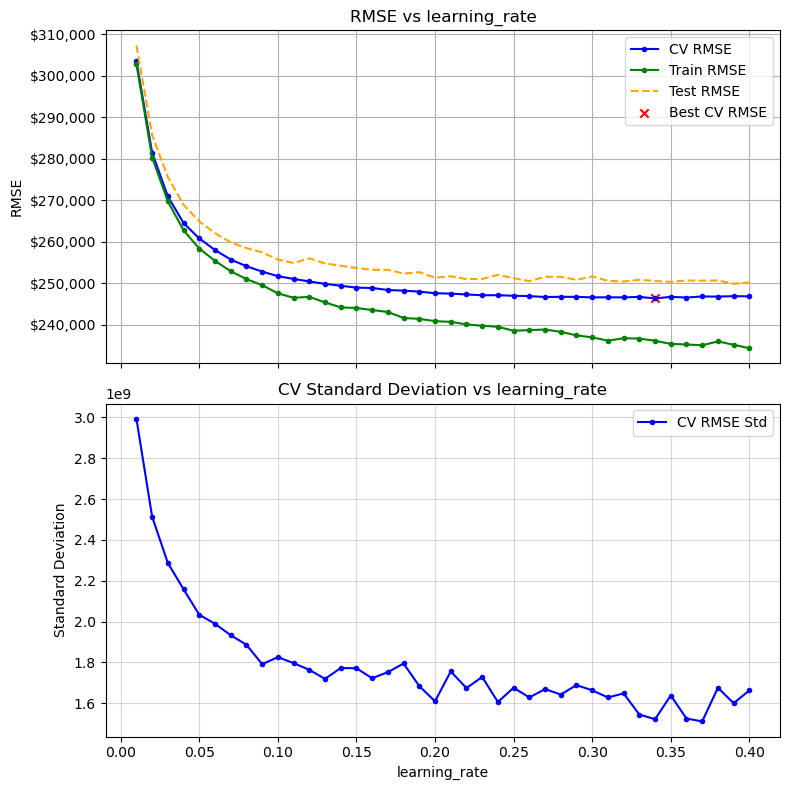

Execution Time: 00:38:39

Parameter learning_rate = 0.34 RMSE = $246,310.94

{'learning_rate': 0.34, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 60669076814.15315}


Sweeping n_estimators: 100%|██████████| 10/10 [24:57<00:00, 149.78s/it]


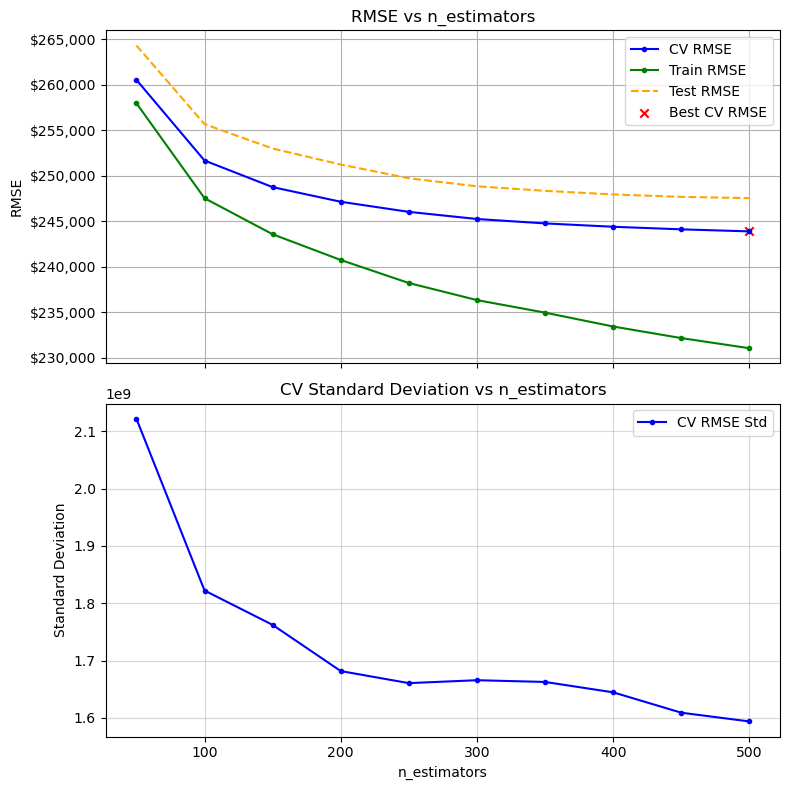

Execution Time: 00:24:57

Parameter n_estimators = 500 RMSE = $243,898.97

{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 59486709276.92547}


Sweeping max_depth:  69%|██████▉   | 9/13 [25:54<16:06, 241.67s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_depth:  92%|█████████▏| 12/13 [42:40<05:06, 306.38s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_depth: 100%|██████████| 13/13 [48:53<00:00, 225.66s/it]


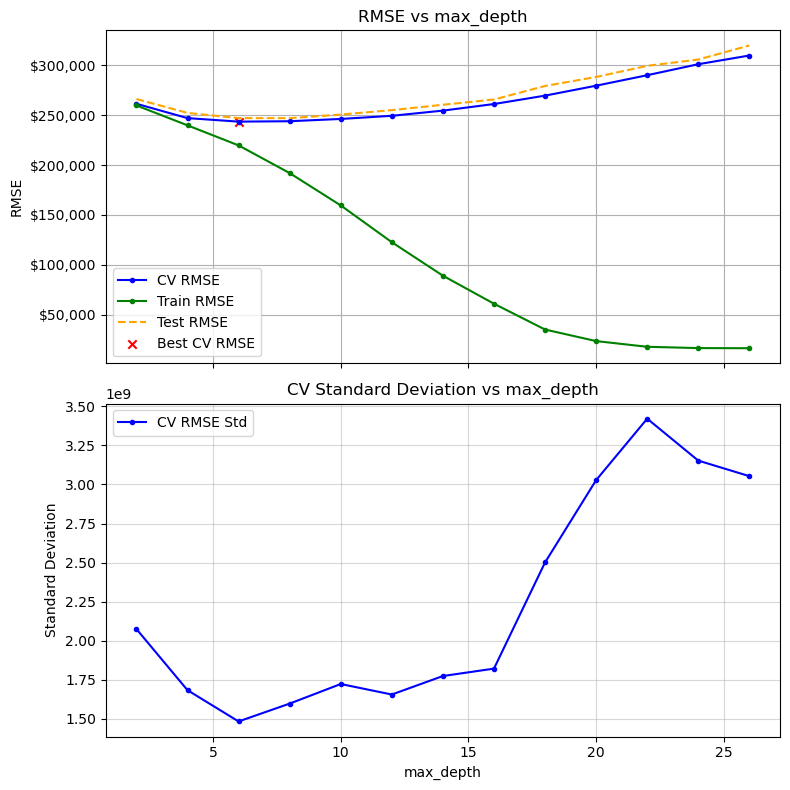

Execution Time: 00:48:53

Parameter max_depth = 6 RMSE = $243,425.96

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 6, 'max_features': None, 'random_state': 42, 'MSE_found': 59256197591.49225}


Sweeping max_features: 100%|██████████| 14/14 [06:55<00:00, 29.69s/it]


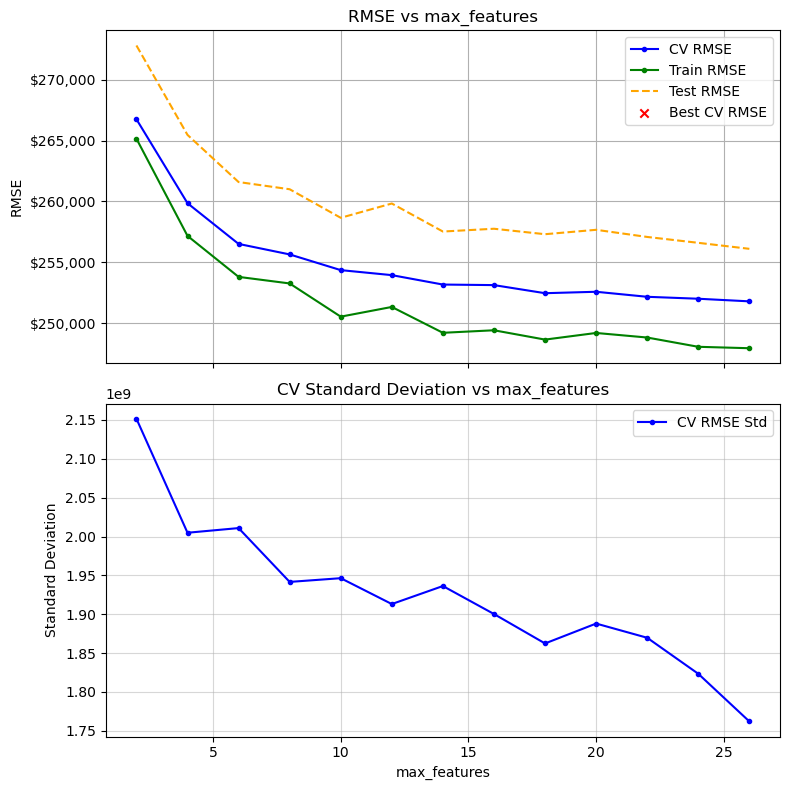

Execution Time: 00:06:55

Parameter max_features = None RMSE = $251,683.34

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 63344502550.85324}


In [47]:
# Make a copy of the default parameters dictionary
GB_Param = Default_Parameters_GradientBoosting.copy()

# Define empty param list for storing
GB_Param_BT_list = []

# Change parameters
GB_Param_ranges = [('learning_rate', np.linspace(0.01, 0.4, 40)),
                   ('n_estimators', range(50, 501, 50)),
                   ('max_depth', range(2, 28, 2)),
                   ('max_features', [None] + list(range(2, 28, 2)))
                   ]

for (param, parameter_list) in GB_Param_ranges:
    GB_Param_BT = sweep_parameter(GradientBoostingRegressor,
                                    GB_Param,
                                    param,
                                    parameter_list,
                                    n_repeats = 5
                                    )

    print(f"\nParameter {param} = {GB_Param_BT[param]} RMSE = ${GB_Param_BT['MSE_found']**0.5:,.2f}\n")
    print(GB_Param_BT)

    # Store best parameters and show in dataframe
    GB_Param_BT_list.append(GB_Param_BT)

results_b = pd.DataFrame(GB_Param_BT_list)

In [52]:
results_b

,learning_rate,n_estimators,max_depth,max_features,random_state,MSE_found
0,0.34,100,3,None,42,6.066908e+10
1,0.10,500,3,None,42,5.948671e+10
2,0.10,100,6,None,42,5.925620e+10
3,0.10,100,3,None,42,6.334450e+10


In [68]:
gbr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gbr_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

gbr_search = RandomizedSearchCV(
    gbr_pipeline,
    gbr_params,
    n_iter=4,  
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1  
)

gbr_search.fit(X, y)

gbr_best_rmse = -gbr_search.best_score_
gbr_std = gbr_search.cv_results_['std_test_score'][gbr_search.best_index_]


gbr_best_rmse = -gbr_search.best_score_
gbr_std = -gbr_search.cv_results_['std_test_score'][gbr_search.best_index_]

# Print Gradient Boosting results
print("Gradient Boosting Results:")
print("Best Parameters:", gbr_search.best_params_)
print("Best CV RMSE:", round(gbr_best_rmse, 4))
print("Standard Deviation:", round(gbr_std, 4))

Gradient Boosting Results:
Best Parameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1}
Best CV RMSE: 242867.475
Standard Deviation: -3668.9759


### C. Random Forest

In [48]:
# Define the parameters for the Random Forest

Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
    'MSE_found'   : float('inf') # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                 # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

Sweeping n_estimators:  30%|███       | 3/10 [11:06<28:53, 247.58s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping n_estimators:  40%|████      | 4/10 [18:59<33:39, 336.63s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping n_estimators:  60%|██████    | 6/10 [40:43<34:53, 523.40s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn

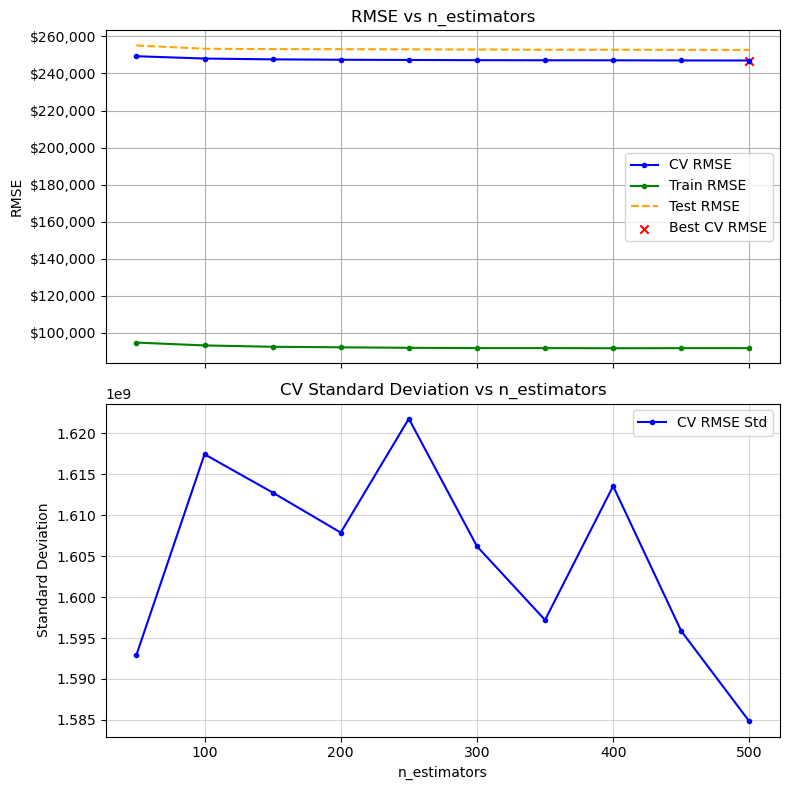

Execution Time: 01:48:49

Parameter n_estimators = 500 RMSE = $247,012.85

{'n_estimators': 500, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': 61015346505.20577}


Sweeping max_features:  15%|█▌        | 2/13 [01:09<06:37, 36.11s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_features:  23%|██▎       | 3/13 [02:07<07:37, 45.75s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_features:  31%|███       | 4/13 [03:18<08:22, 55.81s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
S

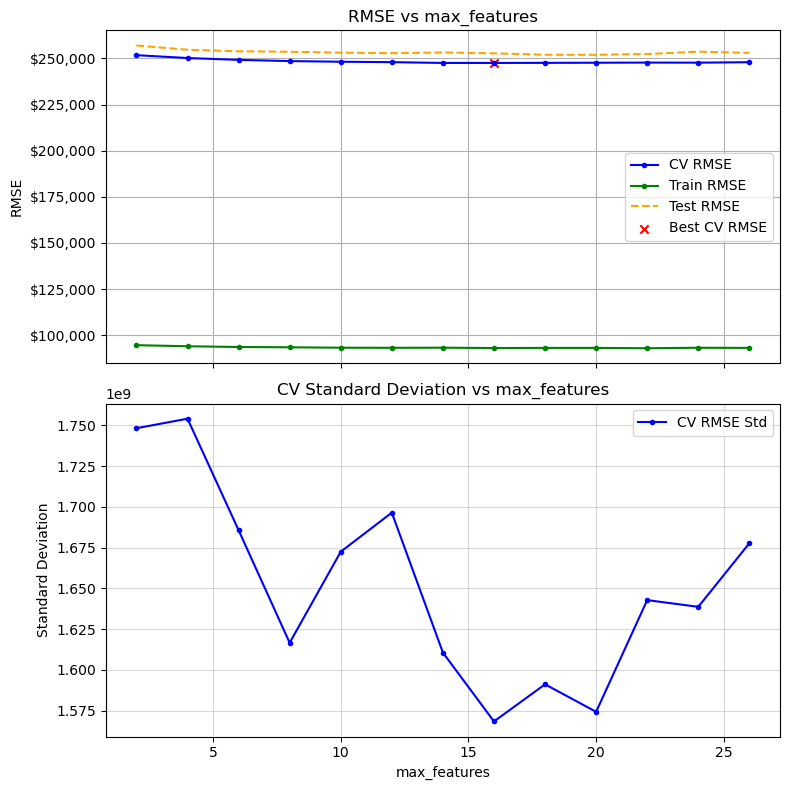

Execution Time: 00:26:28

Parameter max_features = 16 RMSE = $247,513.50

{'n_estimators': 100, 'max_features': 16, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': 61262932736.41979}


Sweeping max_depth:  28%|██▊       | 5/18 [07:24<15:27, 71.37s/it]   /opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_depth:  94%|█████████▍| 17/18 [34:47<02:45, 165.54s/it]/opt/miniconda3/envs/py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_depth: 100%|██████████| 18/18 [38:05<00:00, 127.00s/it]


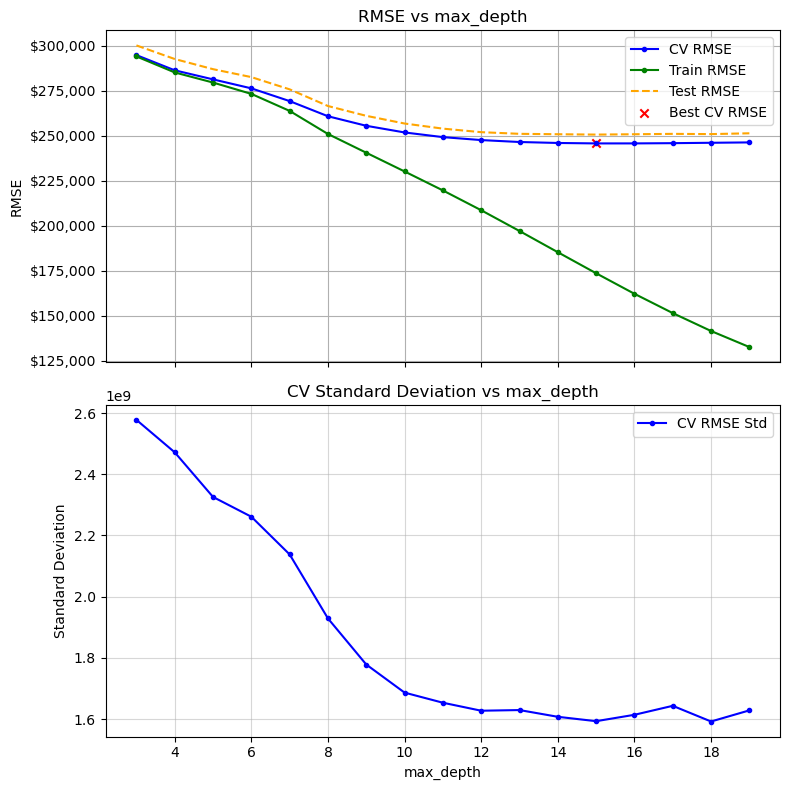

Execution Time: 00:38:06

Parameter max_depth = 15 RMSE = $245,769.41

{'n_estimators': 100, 'max_features': None, 'max_depth': 15, 'bootstrap': True, 'random_state': 42, 'MSE_found': 60402605185.00275}


In [49]:
# Make a copy of the default parameters dictionary
Parameters_RF_baseline = Default_Parameters_Random_Forests.copy()

# Define empty param list for storing
RF_Param_BT_list = []

# Change parameters
RF_Param_ranges = [('n_estimators', range(50, 501, 50)),
                ('max_features', range(2, 28, 2)),
                ('max_depth', [None]+ list(range(3, 20)))
                ]

for (param, parameter_list) in RF_Param_ranges:
    RF_Param_BT = sweep_parameter(RandomForestRegressor,
                                    Parameters_RF_baseline,
                                    param,
                                    parameter_list,
                                    n_repeats = 5
                                    )

    print(f"\nParameter {param} = {RF_Param_BT[param]} RMSE = ${RF_Param_BT['MSE_found']**0.5:,.2f}\n")
    print(RF_Param_BT)

    # Store best parameters and show in dataframe
    RF_Param_BT_list.append(RF_Param_BT)

results_c = pd.DataFrame(RF_Param_BT_list)

In [51]:
results_c

,n_estimators,max_features,max_depth,bootstrap,random_state,MSE_found
0,500,NaN,NaN,True,42,6.101535e+10
1,100,16.0,NaN,True,42,6.126293e+10
2,100,NaN,15.0,True,42,6.040261e+10


In [70]:
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# hyperparameter grid
rf_params = {
    'regressor__n_estimators': [50, 100],  
    'regressor__max_depth': [10],         
    'regressor__min_samples_split': [3, 4, 5]    
}

rf_random = RandomizedSearchCV(
    rf_pipeline,
    rf_params,
    n_iter=5,             
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X, y)

rf_best_rmse = -rf_random.best_score_
rf_std = -rf_random.cv_results_['std_test_score'][rf_random.best_index_]

#Print Random Forest results too
print("\nRandom Forest Results:")
print("Best Parameters:", rf_random.best_params_)
print("Best CV RMSE:", rf_best_rmse)
print("Standard Deviation:", rf_std)


Random Forest Results:
Best Parameters: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 3, 'regressor__max_depth': 10}
Best CV RMSE: 251977.92867427325
Standard Deviation: -4290.750656177197


In [71]:
summary_df = pd.DataFrame({
    'Model': ['Random Forest', 'Bagging Regressor', 'Gradient Boosting'],
    'Mean CV RMSE': [rf_best_rmse, bagging_best_rmse, gbr_best_rmse],
    'Std Dev': [rf_std, bagging_std, gbr_std]
})

print(summary_df)

               Model   Mean CV RMSE      Std Dev
0      Random Forest  251977.928674 -4290.750656
1  Bagging Regressor  249172.419200  4429.600604
2  Gradient Boosting  242867.474970 -3668.975902


### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?

> We started with GridSearchCV and a general parameter sweep, but due to long runtimes, we switched to RandomizedSearchCV to speed things up while still tuning the most important parameters. For Random Forest, we focused on n_estimators, max_depth, and min_samples_split to balance complexity and overfitting. For Bagging, we tuned n_estimators, max_samples, and max_features to reduce variance and diversify the input to each base learner. For Gradient Boosting, we adjusted n_estimators, learning_rate, and max_depth — key parameters for controlling how the model learns and generalizes.

- Did you find that certain types of preprocessing or feature engineering worked better with specific models?

> All models used the same preprocessing: mean imputation for missing values and StandardScaler for feature scaling. Tree models don’t usually need scaling, but we kept it for consistency and because it can help when tuning things like max_features. We didn’t test alternative feature engineering in this round, but future iterations could include log transforms or interaction terms — especially useful for models like Gradient Boosting.


- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.

> We ranked Gradient Boosting highest due to its best RMSE performance and ability to generalize well with proper tuning. While it's slower to train, it’s often more robust. Bagging had comparable performance with faster training, and Random Forest was the most interpretable, but had slightly higher RMSE.

- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

>The workflow delivered as expected — ensemble models outperformed the rest. That said, going back through tuning, evaluation, and even the initial cleaning steps could still help. Exploring new feature transformations, addressing multicollinearity, or adding domain-driven inputs might improve stability and reduce variance. Given time and diminishing returns, I feel this round covered the most impactful steps. But more iteration, especially around feature selection and tuning, would still add value. 